In [1]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import imodelsx.process_results
import pickle as pkl
from collections import defaultdict
import viz
import sys
import notebook_helper
from matplotlib.backends.backend_pdf import PdfPages
sys.path.append('../experiments/')
# results_dir = '/home/chansingh/mntv1/tree-prompt/feb25'
# results_dir = '/home/chansingh/mntv1/tree-prompt/mar17'
results_dir = '/home/chansingh/mntv1/tree-prompt/mar18'

r = imodelsx.process_results.get_results_df(results_dir)
experiment_filename = '../experiments/01_fit.py'
r = imodelsx.process_results.fill_missing_args_with_default(r, experiment_filename)
r['mean_llm_calls'] = notebook_helper.add_mean_llm_calls(r)
r = r[r.model_name != 'manual_rf']
r.to_pickle('../results/tprompt_results.pkl')

r = pd.read_pickle('../results/tprompt_results.pkl')
ravg = r[r.seed == 1]

100%|██████████| 722/722 [01:05<00:00, 11.07it/s]
/home/chansingh/imodelsx/.venv/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations


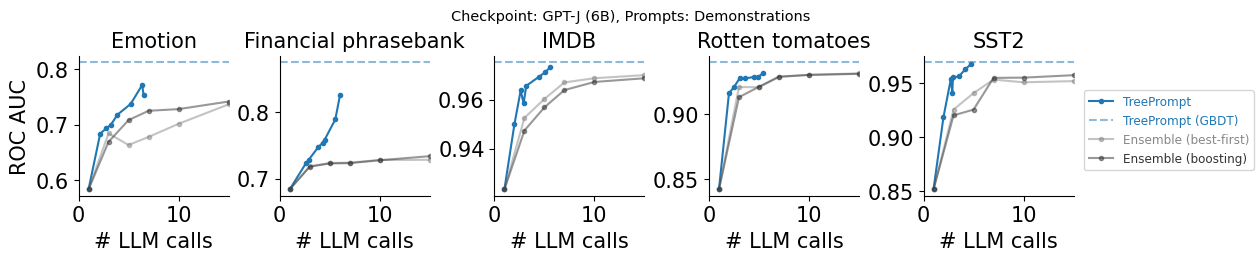

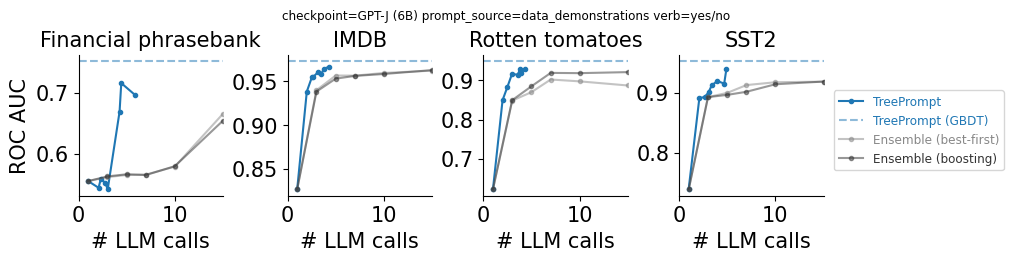

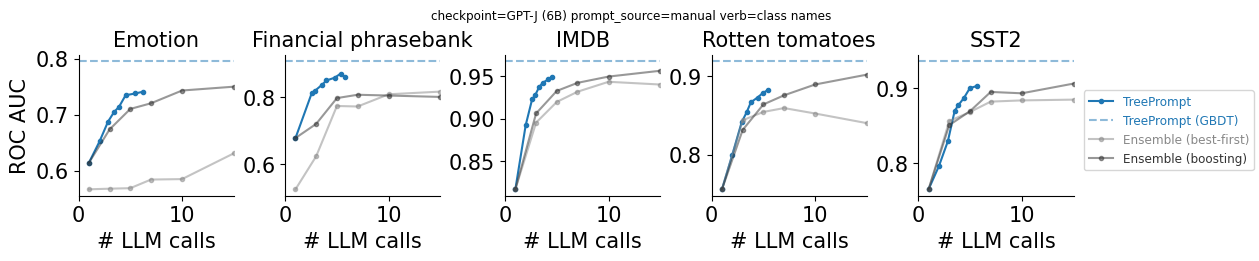

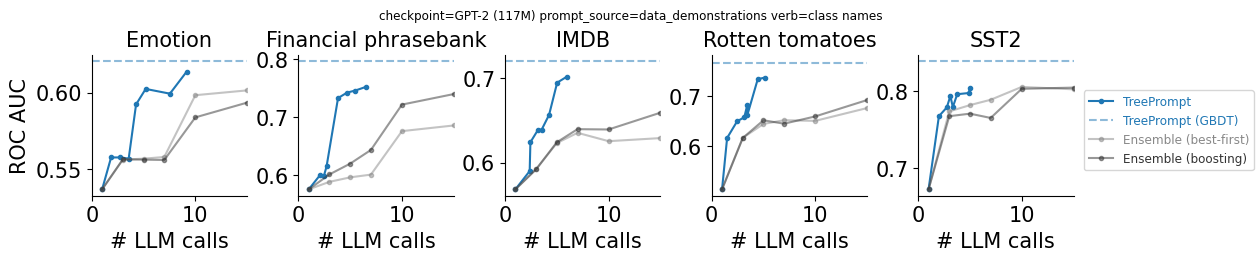

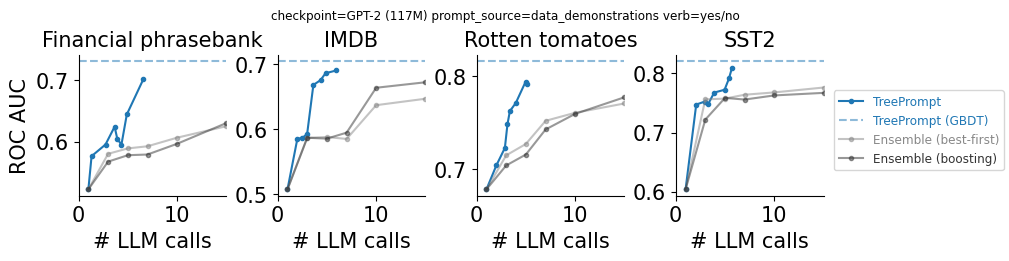

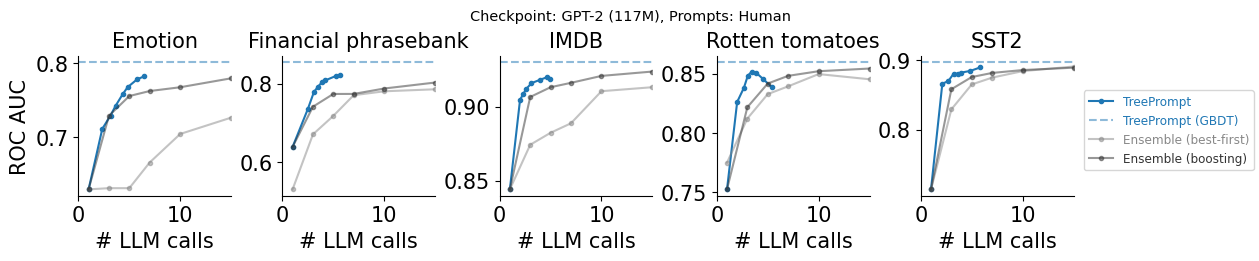

In [15]:
groupings = ['checkpoint', 'prompt_source', 'verbalizer_num'] #, 'binary_classification']
for k, rcurve in ravg.groupby(groupings):
    rcurve = rcurve.sort_values(by=['dataset_name', 'model_name', 'mean_llm_calls'])

    metric = 'roc_auc_test'
    # metric = 'accuracy'
    x = 'mean_llm_calls'                # x = 'num_prompts'

    viz.plot_perf_curves_individual(rcurve, x=x, xlim=15, metric=metric)
    x = rcurve.iloc[0]
    plt.suptitle(f'''checkpoint={viz.CHECKPOINTS_RENAME_DICT[x.checkpoint]} prompt_source={x.prompt_source} verb={viz.VERBS_RENAME_DICT[x.verbalizer_num]}''', fontsize='xx-small')
    # plt.tight_layout()
    # plt.show()

    # save a couple
    row = rcurve.iloc[0]
    if row.checkpoint == 'EleutherAI/gpt-j-6B' and row.prompt_source == 'data_demonstrations' and row.verbalizer_num == 0:
        plt.suptitle(f'Checkpoint: {viz.CHECKPOINTS_RENAME_DICT[x.checkpoint]}, Prompts: {viz.SOURCE_RENAME_DICT.get(x.prompt_source, x.prompt_source)}', fontsize='x-small')
        plt.savefig('../results/figs/perf_curves_gptj.pdf', bbox_inches='tight')
    if row.checkpoint == 'gpt2' and row.prompt_source == 'manual' and row.verbalizer_num == 0:
        plt.suptitle(f'Checkpoint: {viz.CHECKPOINTS_RENAME_DICT[x.checkpoint]}, Prompts: {viz.SOURCE_RENAME_DICT.get(x.prompt_source, x.prompt_source)}', fontsize='x-small')
        plt.savefig('../results/figs/perf_curves_gpt2.pdf', bbox_inches='tight')

viz.save_figs_to_single_pdf("all_results.pdf")

### Apply cross-validation

In [3]:
# apply cross validation
ravg_cv = (
    ravg
    .sort_values(by='accuracy_cv', ascending=False)
    .groupby(by=['split_strategy', 'dataset_name'])
    .first()
    .reset_index()
)
ravg_cv

,split_strategy,dataset_name,seed,save_dir,model_name,max_depth,num_prompts,checkpoint,checkpoint_prompting,verbalizer_num,...,recall_train,brier_score_loss_train,precision_cv,recall_cv,brier_score_loss_cv,precision_test,recall_test,brier_score_loss_test,str_tree,mean_llm_calls
0,iprompt,emotion,1,/home/chansingh/mntv1/tree-prompt/mar18,manual_gbdt,2,40,EleutherAI/gpt-j-6B,EleutherAI/gpt-j-6B,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GradientBoostingClassifier(random_state=1),25.0
1,iprompt,financial_phrasebank,1,/home/chansingh/mntv1/tree-prompt/mar18,manual_gbdt,2,40,EleutherAI/gpt-j-6B,EleutherAI/gpt-j-6B,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GradientBoostingClassifier(random_state=1),25.0
2,iprompt,imdb,1,/home/chansingh/mntv1/tree-prompt/mar18,manual_gbdt,2,40,EleutherAI/gpt-j-6B,EleutherAI/gpt-j-6B,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,|--- Input: This is simply a classic film wher...,25.0
3,iprompt,rotten_tomatoes,1,/home/chansingh/mntv1/tree-prompt/mar18,manual_gbdt,2,40,EleutherAI/gpt-j-6B,EleutherAI/gpt-j-6B,0,...,0.898916,0.067713,0.917037,0.880512,0.077449,0.920233,0.887430,0.079047,GradientBoostingClassifier(random_state=1),25.0
4,iprompt,sst2,1,/home/chansingh/mntv1/tree-prompt/mar18,manual_gbdt,2,40,EleutherAI/gpt-j-6B,EleutherAI/gpt-j-6B,0,...,0.905024,0.069239,0.931436,0.899169,0.070145,0.939394,0.907658,0.060909,GradientBoostingClassifier(random_state=1),25.0


# Select individual results

In [4]:
rd = ravg
groupings2 = ['checkpoint', 'prompt_source', 'verbalizer_num', 'dataset_name', 'model_name']

dset_names = rd.dataset_name.unique().tolist()
mets = defaultdict(list)
for k, rcurve in rd.groupby(groupings2):    
    # rcurve = rcurve.sort_values(by='accuracy_cv', ascending=False)
    # metadata
    for kk in groupings2:
        mets[kk].append(rcurve.iloc[0][kk])
    mets['roc_auc<=5'].append(rcurve[rcurve['mean_llm_calls'] <= 5]['roc_auc_test'].max())

df = pd.DataFrame.from_dict(mets)
df['dataset_name'] = df['dataset_name'].apply(viz.DSETS_RENAME_DICT_ABBR.get)
df['model_name'] = df['model_name'].apply(viz.MODELS_RENAME_DICT.get)
df['checkpoint'] = df['checkpoint'].apply(viz.CHECKPOINTS_RENAME_DICT.get)
# df['prompt_source'] = df['prompt_source'].apply(viz.PROMPT_SOURCES_RENAME_DICT.get)
# print(df.style.hide().to_latex())
dfp = df.pivot_table(index=['checkpoint', 'prompt_source', 'verbalizer_num'], columns=['model_name', 'dataset_name'], values='roc_auc<=5').round(2)
print(dfp.to_latex().replace('NaN', '----'))

\begin{tabular}{lllrrrrrrrrrrrrrrr}
\toprule
 &  & model_name & \multicolumn{5}{r}{Ensemble (best-first)} & \multicolumn{5}{r}{Ensemble (boosting)} & \multicolumn{5}{r}{TreePrompt} \\
 &  & dataset_name & Emotion & FPB & IMDB & RT & SST2 & Emotion & FPB & IMDB & RT & SST2 & Emotion & FPB & IMDB & RT & SST2 \\
checkpoint & prompt_source & verbalizer_num &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{3}{*}{GPT-2 (117M)} & \multirow[t]{2}{*}{data_demonstrations} & 0 & 0.560000 & 0.600000 & 0.620000 & 0.640000 & 0.780000 & 0.560000 & 0.620000 & 0.620000 & 0.650000 & 0.770000 & 0.590000 & 0.740000 & 0.660000 & 0.730000 & 0.800000 \\
 &  & 1 & ---- & 0.590000 & 0.590000 & 0.730000 & 0.760000 & ---- & 0.580000 & 0.590000 & 0.720000 & 0.760000 & ---- & 0.640000 & 0.690000 & 0.790000 & 0.770000 \\
\cline{2-18}
 & manual & 0 & 0.630000 & 0.720000 & 0.880000 & 0.830000 & 0.870000 & 0.760000 & 0.770000 & 0.910000 & 0.840000 & 0.880000 & 0.770000 & 0.810000 & 0.920000 & 0.850

In [5]:
d = df
d = d[~(d['model_name'] == 'TreePrompt (GBDT)')]

/tmp/ipykernel_2654859/2913977604.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


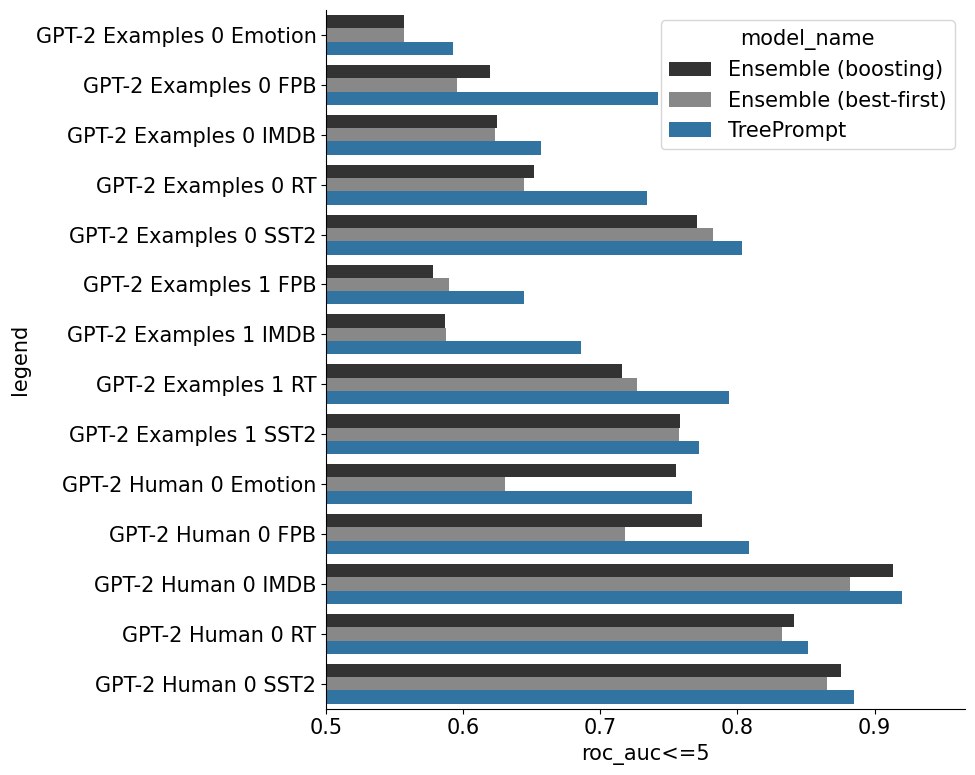

In [6]:
d['legend'] =  d['checkpoint'].map({'GPT-2 (117M)': 'GPT-2', 'GPT-J (6B)': 'GPT-J'}) + ' ' \
        + d['prompt_source'].map({'data_demonstrations': 'Examples', 'manual': 'Human'}) + ' ' \
            + d['verbalizer_num'].astype(str) + ' ' + d['dataset_name']

dd = d[d.checkpoint == 'GPT-2 (117M)']
plt.figure(figsize=(10, 8))
sns.barplot(y='legend', x='roc_auc<=5', hue='model_name', data=dd,
palette = viz.COLORS_RENAMED_DICT)
plt.xlim(left=0.5)
plt.show()